MNIST, with and without MC Dropout

In [30]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pandas as pd
from tqdm.auto import tqdm
from timeit import default_timer as timer

# Setup training data
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# Setup testing data
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"

# evaluation metric
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# CNN without dropout
class MNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super(MNISTModel, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# CNN with dropout
class MNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super(MNISTModelV2, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

# ApplyingMC dropout method
def mc_dropout_predictions(model, data, num_samples=10):
    model.eval()
    predictions = torch.zeros((num_samples, len(data), 10))
    with torch.no_grad():
        for i in range(num_samples):
            outputs = model(data)
            predictions[i] = torch.softmax(outputs, dim=1)
    return predictions.mean(dim=0)

# Evaluation function
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               mc_dropout: bool = False,
               num_samples: int = 10):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            if mc_dropout:
                y_pred = mc_dropout_predictions(model, X, num_samples)
            else:
                y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

#Training and evaluation without dropout
print("Training and evaluating model without dropout...")
torch.manual_seed(42)
model_without_dropout = MNISTModel(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model_without_dropout.parameters(), lr=0.1)

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1)
            )

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

# Training
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_without_dropout,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_without_dropout,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

# Evaluation
model_without_dropout_results = eval_model(
    model=model_without_dropout,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

#Training and evaluation with dropout
print("Training and evaluating model with dropout...")
torch.manual_seed(42)
model_with_dropout = MNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model_with_dropout.parameters(), lr=0.1)

# Training
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_with_dropout,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_with_dropout,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

# Evaluation
model_with_dropout_results = eval_model(
    model=model_with_dropout,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

#results
results_data = {
    "Model": ["Without Dropout", "With Dropout"],
    "Loss": [model_without_dropout_results["model_loss"], model_with_dropout_results["model_loss"]],
    "Accuracy": [model_without_dropout_results["model_acc"], model_with_dropout_results["model_acc"]]
}

results_1 = pd.DataFrame(results_data)

print(results_1)


Training and evaluating model without dropout...


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.26457 | Train accuracy: 91.34%
Test loss: 0.07055 | Test accuracy: 97.60%

Epoch: 1
---------
Train loss: 0.06728 | Train accuracy: 97.94%
Test loss: 0.04251 | Test accuracy: 98.53%

Epoch: 2
---------
Train loss: 0.05347 | Train accuracy: 98.31%
Test loss: 0.04484 | Test accuracy: 98.44%

Training and evaluating model with dropout...


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.27136 | Train accuracy: 91.13%
Test loss: 0.07242 | Test accuracy: 97.59%

Epoch: 1
---------
Train loss: 0.06845 | Train accuracy: 97.87%
Test loss: 0.04302 | Test accuracy: 98.63%

Epoch: 2
---------
Train loss: 0.05403 | Train accuracy: 98.33%
Test loss: 0.04226 | Test accuracy: 98.51%

             Model      Loss   Accuracy
0  Without Dropout  0.044839  98.442492
1     With Dropout  0.042263  98.512380


2-a

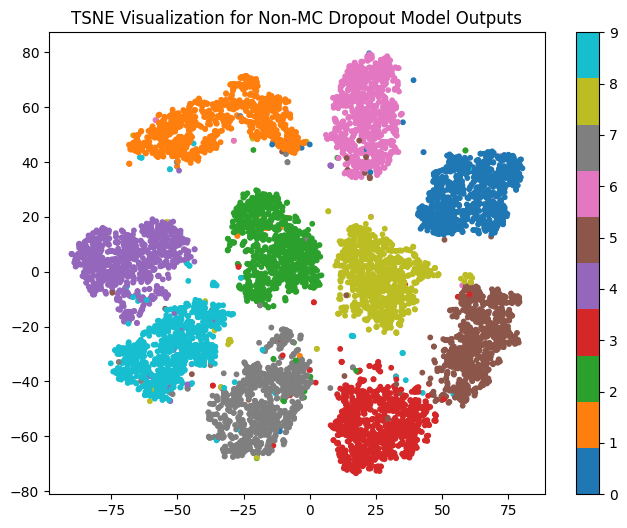

In [27]:
from sklearn.manifold import TSNE
import numpy as np

# Remove the final layer of the non-MC dropout model
non_mc_dropout_model_tsne = MNISTModel(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
non_mc_dropout_model_tsne.load_state_dict(model_without_dropout.state_dict())
non_mc_dropout_model_tsne.classifier = nn.Identity()

# Collect predictions on the test set
non_mc_dropout_model_tsne.eval()
all_predictions = []
with torch.no_grad():
    for X, _ in test_dataloader:
        X = X.to(device)
        predictions = non_mc_dropout_model_tsne(X)
        all_predictions.append(predictions.cpu().numpy())

all_predictions = np.concatenate(all_predictions, axis=0)

# Plot TSNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(all_predictions)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=test_data.targets, cmap='tab10', s=10)
plt.title("TSNE Visualization for Non-MC Dropout Model Outputs")
plt.colorbar()
plt.show()


2-b

In [28]:
from torchvision.datasets import FashionMNIST

# Load Fashion MNIST dataset
fashion_test_data = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

fashion_test_dataloader = DataLoader(fashion_test_data,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)

# Predict and check accuracy and uncertainty
non_mc_dropout_model_tsne.eval()
correct = 0
total = 0
uncertainty_sum = 0

with torch.no_grad():
    for X, y in fashion_test_dataloader:
        X, y = X.to(device), y.to(device)
        predictions = non_mc_dropout_model_tsne(X)
        _, predicted = torch.max(predictions, 1)
        correct += (predicted == y).sum().item()
        uncertainty_sum += torch.softmax(predictions, dim=1).max(dim=1)[0].sum().item()
        total += y.size(0)

accuracy = correct / total
average_uncertainty = uncertainty_sum / total

print(f"Accuracy on Fashion MNIST: {accuracy * 100:.2f}%")
print(f"Average Uncertainty on Fashion MNIST: {average_uncertainty:.4f}")


100%|██████████| 26421880/26421880 [00:00<00:00, 100118074.03it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5270334.31it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 66064848.34it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7226330.99it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Accuracy on Fashion MNIST: 0.01%
Average Uncertainty on Fashion MNIST: 0.0589


2-c

Epoch 1/10, Loss: 0.39050128097335496
Epoch 2/10, Loss: 0.2359945310657223
Epoch 3/10, Loss: 0.20576264604839187
Epoch 4/10, Loss: 0.1912058797352016
Epoch 5/10, Loss: 0.18043457159201304
Epoch 6/10, Loss: 0.17117709337634346
Epoch 7/10, Loss: 0.1651671860896051
Epoch 8/10, Loss: 0.15983741529416293
Epoch 9/10, Loss: 0.1543803327963998
Epoch 10/10, Loss: 0.15231093345675617
Non-MC Dropout Model Accuracy: 93.62%


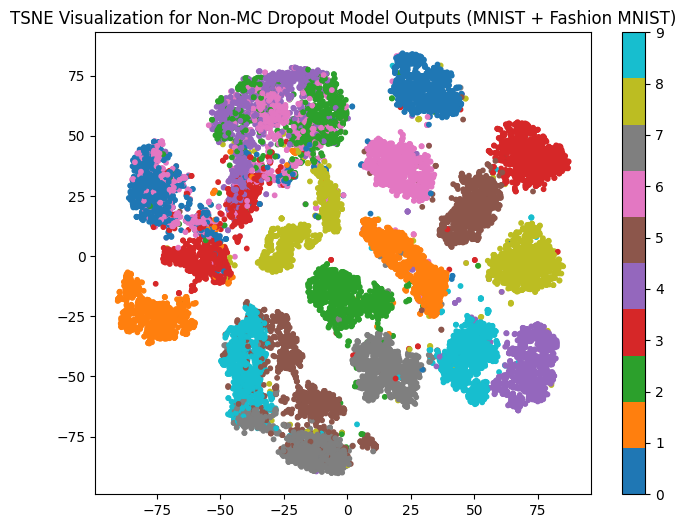

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
fashion_mnist_train_data = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
fashion_mnist_test_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Combine the datasets
combined_train_data = ConcatDataset([mnist_train_data, fashion_mnist_train_data])
combined_test_data = ConcatDataset([mnist_test_data, fashion_mnist_test_data])

BATCH_SIZE = 32
combined_train_dataloader = DataLoader(combined_train_data, batch_size=BATCH_SIZE, shuffle=True)
combined_test_dataloader = DataLoader(combined_test_data, batch_size=BATCH_SIZE, shuffle=False)

# CNN model without MC Dropout
class MNISTModel(nn.Module):
    def __init__(self, input_shape=1, hidden_units=10, output_shape=10):
        super(MNISTModel, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

non_mc_dropout_model = MNISTModel(input_shape=1, hidden_units=10, output_shape=10).to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(non_mc_dropout_model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    non_mc_dropout_model.train()
    running_loss = 0.0
    for images, labels in combined_train_dataloader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = non_mc_dropout_model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(combined_train_dataloader)}")

#model's weights
torch.save(non_mc_dropout_model.state_dict(), "non_mc_dropout_model.pth")

# Evaluate the non-MC Dropout model
def eval_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

non_mc_dropout_model_accuracy = eval_model(non_mc_dropout_model, combined_test_dataloader)
print(f"Non-MC Dropout Model Accuracy: {non_mc_dropout_model_accuracy:.2f}%")

# Perform TSNE for the non-MC Dropout model
non_mc_dropout_model_tsne = MNISTModel(input_shape=1, hidden_units=10, output_shape=10).to(device)
non_mc_dropout_model_tsne.load_state_dict(non_mc_dropout_model.state_dict())
non_mc_dropout_model_tsne.classifier = nn.Identity()  # Remove the final layer

# Predict on combined dataset and plot TSNE visualization
non_mc_dropout_model_tsne.eval()
all_predictions_combined = []
combined_targets = []
with torch.no_grad():
    for X, y in combined_test_dataloader:
        X = X.to(device)
        y = y.to(device)
        predictions = non_mc_dropout_model_tsne(X)
        all_predictions_combined.append(predictions.cpu().numpy())
        combined_targets.extend(y.cpu().numpy())

all_predictions_combined = np.concatenate(all_predictions_combined, axis=0)

# Perform TSNE and plot the visualization
tsne_combined = TSNE(n_components=2, random_state=42)
tsne_result_combined = tsne_combined.fit_transform(all_predictions_combined)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result_combined[:, 0], tsne_result_combined[:, 1], c=combined_targets, cmap='tab10', s=10)
plt.title("TSNE Visualization for Non-MC Dropout Model Outputs (MNIST + Fashion MNIST)")
plt.colorbar()
plt.show()
